<a href="https://colab.research.google.com/github/daviddralle/recharge_ratios/blob/main/recharge_ratios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone https://www.github.com/daviddralle/indirect_storage
!git clone https://github.com/daviddralle/daviddralle.github.io
!pip install -q rasterio
!pip install -q geopandas
!pip install -q georasters

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import glob
import scipy.io as sio
from scipy.signal import savgol_filter
import pickle
import scipy
import warnings
warnings.filterwarnings('ignore')
import datetime
from sklearn.metrics import r2_score
import seaborn as sns
import scipy
import scipy.io as sio
import georasters as gr
import rasterio
import scipy.optimize as optimize
import geopandas as gp
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
from shapely.geometry import Point
import geopandas as gp
from scipy import stats as stats
%config InlineBackend.figure_format = 'retina'

In [3]:
# Sensitivity function [see Kirchner, 2009] doi:10.1029/2008WR006912
def g(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]

# Bin dq/dt data
def KirchnerBinning(df, min_per_bin = 10, loud=False):
    df = df.sort_values('q',ascending=False)
    logQ = np.array(np.log(df.q))
    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*.01
    binBoundaries = [0]
    for i in range(1,len(df)):
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
            if loud: print('Bin too small')
            continue
        if abs(i-binBoundaries[-1]) < min_per_bin:
            if loud: print('Not enough data points')
            continue
        curr = df.dq[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
            if loud: print('Bin too heterogeneous')
            continue
        binBoundaries.append(i)
    return binBoundaries

def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
    try:
      geoms = [item for item in list(basin.geometry[0])]
      idx = np.argmax([item.area for item in geoms])
      basin.geometry = [geoms[idx]]
      print('Found multipolygon - fixing')
    except:
      basin.geometry = basin.geometry
    area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
    df = 2.44657555e12*df[['q']]/area_mm2
    df.q = df.q.astype(float, errors='ignore')
    df.columns = [site]
    return df, basin

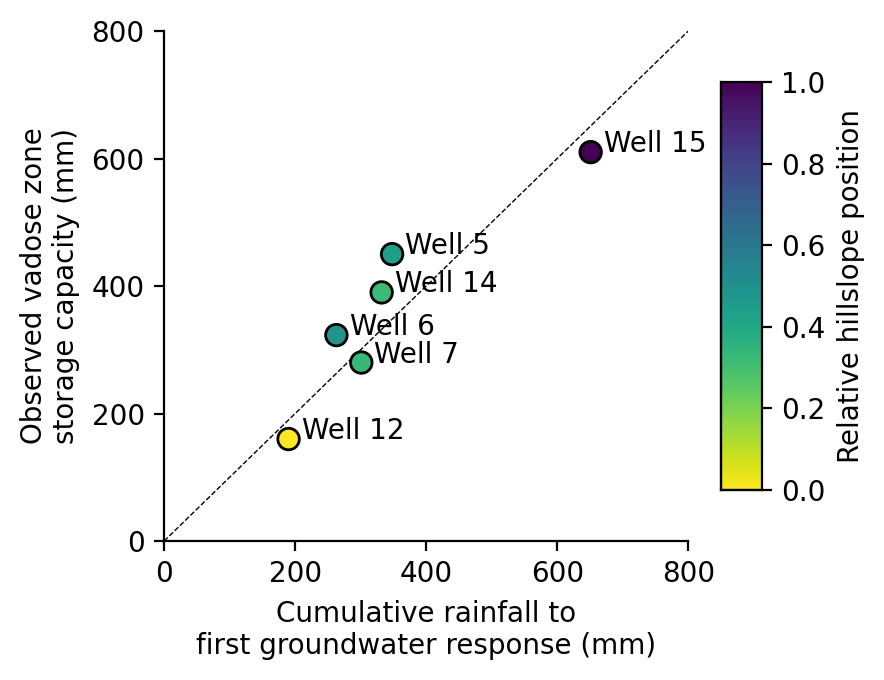

In [4]:
# Load a GeoTIFF of distance from stream
r = gr.from_file('./daviddralle.github.io/distance_stream.tif')

# Call the getFlow function to get basin information and save it as a GeoJSON file
q, basin = getFlow('11475560','2010-01-01','2022-10-01')
basin.to_crs('epsg:26910').to_file('./elder.geojson')

# Clip distance raster
clipped = r.clip('./elder.geojson')[0]
clipped.to_tiff('./clipped_distance')

# Define dictionaries for soil rock and maximum storage capacity and rainfall response for each well
# Values taken from Rempe et al 2018
srock = {12:100,2:270,13:170,14:330,5:390,6:263, 7:220,15:550}
ssoil = 60
smaxs = {i:srock[i]+ssoil for i in list(srock)}
resp = {12:190,14:332,5:348,6:263,7:301,15:651}

# Open the clipped TIFF file and load the well lat/long locations from a MAT file
src = rasterio.open('./clipped_distance.tif')
wells = sio.loadmat('./daviddralle.github.io/RivendellWellsXYZnum.mat')
poly = gp.read_file('./elder.geojson')
wells = wells['RivendellWells']
dfs = []

# Iterate through the wells and create a GeoDataFrame of dist from stream
for i in range(np.shape(wells)[0]):
    pt = wells[i,0:2]
    x,y = pt[0],pt[1]
    wellnum = int(wells[i,3])
    if wellnum in smaxs.keys():
        value = [item for item in src.sample([(x, y)])][0][0]
        pt = [Point(pt)]
        pt = gp.GeoDataFrame({'distance':value},index=[wellnum], geometry=pt, crs=poly.crs)
        dfs.append(pt)

# Concatenate the GeoDataFrames and add columns for soil rock, soil
# storage capacity in VZ, and cumulative rainfall to first GW response
df = pd.concat(dfs)
df['srock'] = df.index.map(srock)
df['ssoil'] = ssoil
df['smax'] = df.srock + df.ssoil
df['resp'] = df.index.map(resp)

# Sort the GeoDataFrame by distance from stream
df = df.sort_values('distance')

# Create a scatter plot of first response and  storage capacity
# with relative hillslope position as the color map
f,ax = plt.subplots(figsize=(4.5,3.5))
cs = df['distance'].values
y = df.smax.values
x = df.resp.values
wells = df.index.values
idx = np.isfinite(x)&np.isfinite(y)
x = x[idx]
y = y[idx]
wells = wells[idx]
cs = cs[idx]
cs = (cs - np.min(cs))/(np.max(cs) - np.min(cs))
mappable = ax.scatter(x,y, s=60,c=cs,ec='k',zorder=10,cmap='viridis_r')

# Add text labels for each well and a dashed diagonal line
for i in range(len(x)):
    ax.text(x[i]+20,y[i], 'Well %d'%wells[i],zorder=10)
ax.plot([0,800],[0,800],ls='--',c='k',lw=0.5)

# Add a color bar and adjust plot aesthetics
cb = f.colorbar(mappable,aspect=10.,shrink=.8)
ax.set_ylim(0,800)
ax.set_xlim(0,800)
ts = ax.get_xticks()
ax.set_yticks(ts)
sns.despine()
ax.set_ylabel('Observed vadose zone\nstorage capacity (mm)')
ax.set_xlabel('Cumulative rainfall to\nfirst groundwater response (mm)')
cb.set_label('Relative hillslope position')
f.tight_layout()

# Save the figure as a PDF file
f.savefig('./smax_resp_dist.pdf',dpi=300)


Fit coefficients:
c_3 = 0.063 +/- 0.014
c_2 = 0.439 +/- 0.025
c_1 = -3.127 +/- 0.024


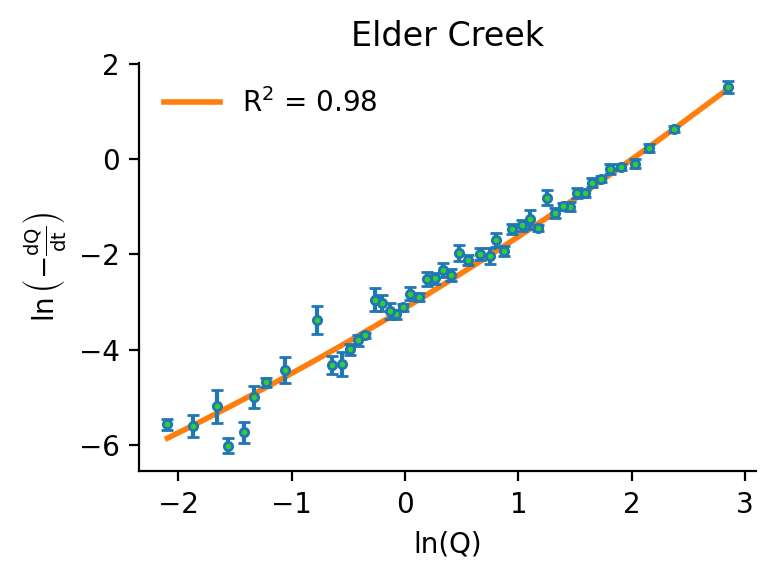

In [13]:
# Read in weather data from a CSV file and resample the rainfall data to daily sums
weather = pd.read_csv('https://hydroeco.github.io/angelo/angelo_weather_1H.csv', parse_dates=True, index_col=0)
ppt = weather['AngeloMeadowWs_Rainfall_TB4'].resample('D').sum()

# Get flow data from a function call and select only common dates with the rainfall data
start = pd.to_datetime(ppt.index.values[0]).strftime('%Y-%m-%d')
stop = pd.to_datetime(ppt.index.values[-1]).strftime('%Y-%m-%d')
q = getFlow('11475560','2010-01-01','2023-10-01')[0]['11475560']
idx = set(q.index.values).intersection(set(ppt.index.values))
q = q.loc[idx].sort_index()
ppt = ppt.loc[idx].sort_index()

# Create lists to store q and its derivative
dqs = []
qs = []
years = list(set(ppt.index.year))
years.sort()

# Iterate through the years and calculate dqs and qs for winter month recessions
for year in years:
    # Do not loop beyond the 2020 water year
    if year>2022:
        continue
    # Only use winter month recessions
    startdate = '11-' + str(year)
    enddate = '4-' + str(year+1)
    rain = np.array(ppt.loc[startdate:enddate])
    rainshift = np.roll(rain,1) + np.roll(rain,-1)
    runoff = np.array(q.loc[startdate:enddate])
    dqdt = np.array(list(np.diff(runoff)) + [0])
    idx = (rain<=1)&(dqdt<=0)&(rainshift<=1)
    dqs = dqs + list(dqdt[idx])
    qs = qs + list(runoff[idx])
dqs = np.array(dqs)
qs = np.array(qs)

allqs = np.copy(qs)

# Sort qs and dqs in descending order and calculate bin boundaries using Kirchner binning
df_kirchner = pd.DataFrame({'q':qs, 'dq':dqs})
df_kirchner = df_kirchner.sort_values('q',ascending=False)
binBoundaries = KirchnerBinning(df_kirchner, min_per_bin=10)

# Calculate the mean qs and dqs and standard errors for each bin and fit a quadratic polynomial to the data
qs = [np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)]
dqs = np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]].loc[df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]<0]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12
p = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=2, w=1/sigmas**2)

# Create a scatter plot of log(qs) and log(-dqs) with error bars and a fitted curve
f,ax = plt.subplots(figsize=(4,3))
ax.errorbar(np.log(qs), np.log(-dqs), yerr = sigmas,fmt='o',capsize=2,**{'ms':3, 'mfc':'limegreen','zorder':1})

# Add the fitted curve to the plot and adjust plot aesthetics
x = np.log(qs)
coefficient_of_dermination = r2_score(np.log(-dqs), p[2] + p[1]*x + p[0]*x**2)
ax.plot(x, p[2] + p[1]*x + p[0]*x**2,lw=2, label='$\mathrm{R^2}$ = %.2f'%coefficient_of_dermination,zorder=-1)
p[1] = p[1]-1
ax.set_xlabel('ln(Q)')
leg = ax.legend(fontsize=10,loc='best')
leg.set_frame_on(False)
ax.set_title('Elder Creek',fontsize=12)
ax.set_ylabel(r'$\ln \left( -\mathrm{\frac{dQ}{dt}}\right)$')
f.tight_layout()
sns.despine()

print('Fit coefficients:')
for i in range(len(p)):
  print('c_%d = %.3f'%(3-i,p[i]) + ' +/- ' +  '%.3f'%(cov[i,i]**(0.5)))

# Save the figure as a PDF file
f.savefig('./dqdt_q.pdf')

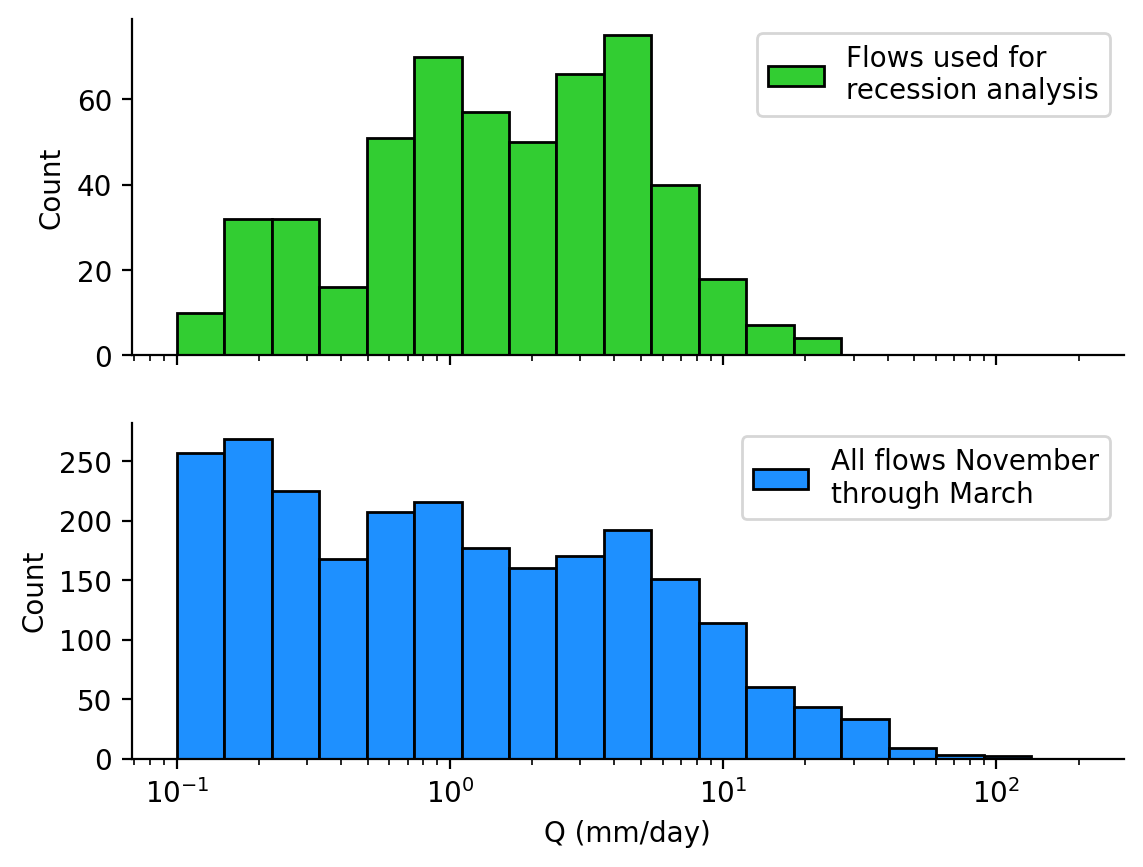

In [14]:
f,axs = plt.subplots(2,1,sharex=True)
ax = axs[0]
ax.hist(allqs, bins=np.logspace(np.log10(0.1),np.log10(200.0), 20),fc='limegreen', ec='k',label='Flows used for\nrecession analysis')
temp = q.loc[q.index.month.isin([11,12,1,2,3])].copy()
ax.set_ylabel('Count')
ax.legend()
ax = axs[1]
ax.hist(q.values,fc='dodgerblue', ec='k',bins=np.logspace(np.log10(0.1),np.log10(200.0), 20),label='All flows November\nthrough March')
ax.set_xscale('log')
sns.despine()
ax.set_ylabel('Count')
ax.set_xlabel('Q (mm/day)')
ax.legend()

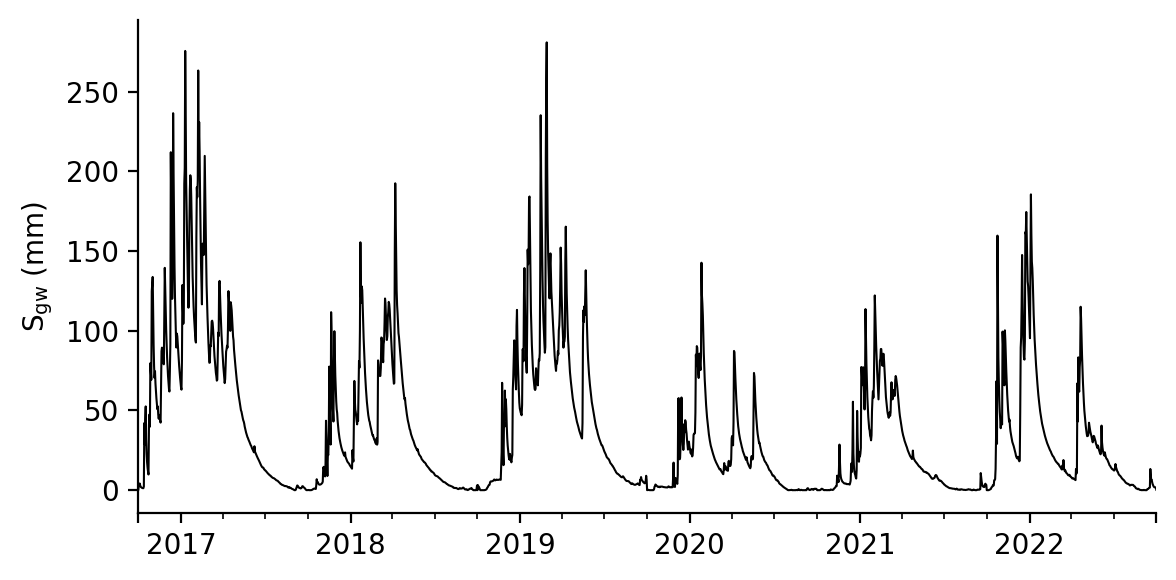

In [15]:
# Create a new DataFrame with columns for q, ppt, and direct_storage and index of q.index
df = pd.DataFrame({'q':q.values,'ppt':ppt.values},index=q.index)

# Iterate through the years and calculate direct storage time series for each year
years = list(set(q.index.year))
years.sort()
df['direct_storage'] = 0
for year in years[1:]:
  startDate = '10-01-' + str(year)
  endDate = '9-30-' + str(year+1)
  thisYear = df.loc[startDate:endDate]
  if len(thisYear)<100:
      continue
  # Calculate dynamic storage time series, assuming 0 at start of wet season
  qvar = thisYear.q.tolist()
  direct_S = [0]
  for i in range(1,len(qvar)):
    qi = qvar[i]
    qi1 = qvar[i-1]
    qintegrate = np.linspace(qi1, qi, 40)
    direct_S.append(direct_S[i-1] + np.trapz([1/gg for gg in g(qintegrate,p)],qintegrate))
    if direct_S[i] < 0:
      direct_S[i] = 0
  df['direct_storage'].loc[startDate:endDate] = direct_S

# Create a plot of direct_storage over time
f,ax = plt.subplots(figsize=(6,3))
df['direct_storage'].plot(ax=ax,c='k',lw=0.75)
sns.despine()
ax.set_xlabel('')
ax.set_xlim('2016-10','2022-10')
ax.set_ylabel(r'$\mathrm{S_{gw}}$ (mm)')
f.tight_layout()

# Save the figure as a PDF file
f.savefig('./sgw.pdf')

In [24]:
# Create a list of years and sort them
years = list(set(q.index.year))
years.sort()

# Add new columns to the DataFrame for recharge (rt)
df['rt'] = 0

# Iterate through the years and calculate rt for each year
for year in years[1:]:
  if year>2021:
    continue
  startDate = '10-01-' + str(year)
  endDate = '9-30-' + str(year+1)
  thisYear = df.loc[startDate:endDate]
  if len(thisYear)<100:
      continue

  # Calculate Sd time series, assuming 0 at start of wet season
  qvar = thisYear.q.tolist()
  rts = [0]
  for i in range(1,len(qvar)):
    # change dt if needed
    dt = 1.0
    qi = qvar[i]
    qi1 = qvar[i-1]
    rt = (qi - qi1)/dt/((g(qi,p) + g(qi1,p))/2) + (qi+qi1)/2
    rts.append(rt)

  rts = np.array(rts)
  # rts[rts<0] = 0
  df['rt'].loc[startDate:endDate] = rts

# Remove duplicate index values and sort by index
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()


# Plot sum(recharge) versus sum(P)

Should probably plot against sum(P-ET), i.e. effective rainfall. Should matter less in 2017 when there was a lot of rain and ET probably mattered less for slowing the wetup.

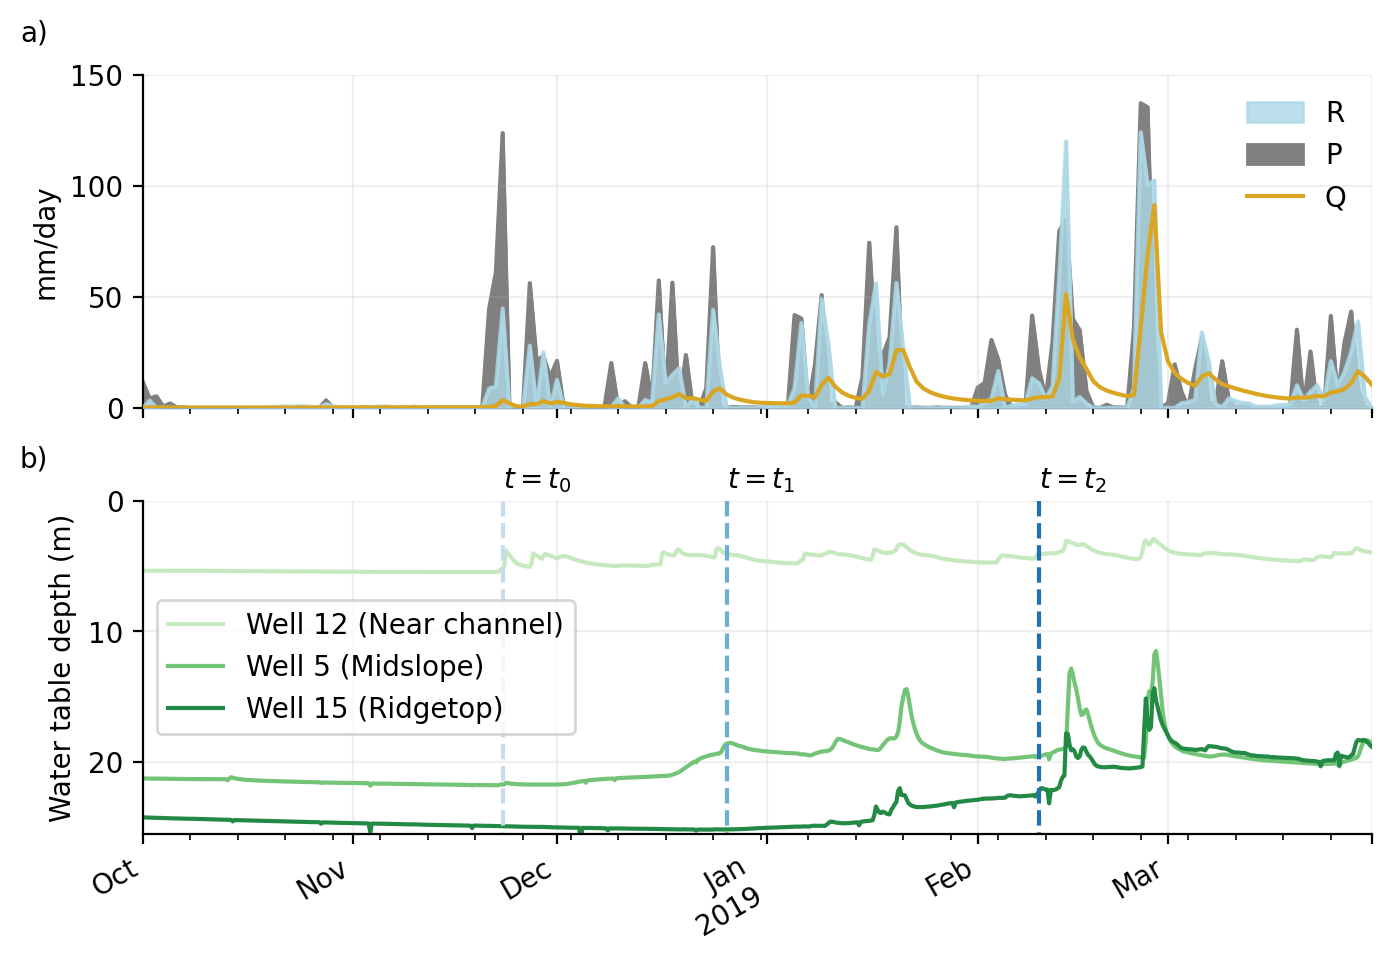

In [22]:
# Define the URL of the groundwater data
url = 'https://raw.githubusercontent.com/hydroeco/hydroeco.github.io/master/angelo/angelo_wells_1H.csv'

# Read the dataset into a DataFrame, parse dates, and set the index column
wells = pd.read_csv(url, parse_dates=True, index_col=0)
wells = wells.iloc[:-1]

# Convert the index to datetime objects
wells.index = pd.to_datetime(wells.index)

# Define the start and stop time for the analysis
starttime = '10-2018'
stoptime = '03-2019'

# Select data within the specified time range
welltemp = wells.loc[starttime:stoptime]

# Define the wells of interest
cols = ['RivLevel12_Well_12_Water_Level',
        'RivLevel41_Well_5_Water_Level', 'RivLevel51_Well_15_Water_Level']

# Calculate the precip response threshold values
threshs = [resp[int(item.split('_')[2])] for item in cols]

# Define positions for the labels
pos = ['Near channel', 'Midslope', 'Ridgetop']

# Define color palettes for the plots
cs = sns.color_palette('Greens', n_colors=len(cols))
cv = sns.color_palette('Blues', n_colors=len(cols))

# Clean up GW data and select columns of interest
welltemp = welltemp[cols]
welltemp = -welltemp.resample('6H').mean().interpolate()

# Initialize a subplot
f, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
ax = axs[1]

# Plot the water table depth for each well
for i, col in enumerate(cols):
    label = col.split('_')[1] + ' ' + col.split('_')[2] + ' (%s)' % pos[i]
    welltemp[col].loc[starttime:stoptime].plot(ax=ax, label=label, c=cs[i])

# Set the y-axis label and limit, invert y-axis, add legend, and adjust grid
ax.set_ylabel('Water table depth (m)')
ax.set_ylim(0, 25.5)
ax.invert_yaxis()
ax.legend()
ax.grid(alpha=0.2)
ax.set_xlabel('')
ax.text(-0.1, 1.1, 'b)', transform=ax.transAxes)

# Define time points of interest, t0, t1, t2
idxs = ['2018-11-23', '2018-12-26', '2019-02-10']

# Add vertical lines at t0, t1, t2
for i, col in enumerate(cols):
    sumP = df.ppt.loc[starttime:stoptime].cumsum()
    thresh = resp[int(col.split('_')[2])]
    idx = idxs[i]
    try:
        ymax = welltemp[col].loc[idx].values[0]
    except:
        ymax = welltemp[col].loc[idx]
    ax.vlines(idx, 0, 100, color=cv[i], ls='--')
    ax.text(idx, -1, rf'$t = t_{i}$')

# Plot the precipitation, recharge, and discharge data
ax = axs[0]
temp = df.copy()
temp.loc[temp.rt<=0,'rt'] = 0
temp.rt.loc[starttime:stoptime].plot(ax=ax, label='R', color='lightblue', alpha=0.8, kind='area', zorder=5)
temp.ppt.loc[starttime:stoptime].plot(ax=ax, label='P', kind='area', color='gray', zorder=-1)
temp.q.loc[starttime:stoptime].plot(ax=ax, label='Q', c='goldenrod', lw=1.5, zorder=10)

# Set the y-axis limit, add legend, remove spines, and set ylabel
ax.set_ylim(0, 150)
ax.legend(framealpha=0)
sns.despine()
ax.set_ylabel('mm/day')

# Set the x-axis label, adjust the layout, and format x-axis dates
ax.set_xlabel('')
f.tight_layout()
f.autofmt_xdate()

# Adjust the grid and add a subplot label
ax.grid(alpha=0.2)
ax.text(-0.1, 1.1, 'a)', transform=ax.transAxes)

# Save the figure as a PDF
f.savefig('./recharge_timeseries_%s.pdf' % stoptime.split('-')[-1], bbox_inches='tight')

# Activation as a continuous concept

If vz progressively wets upslope, activation will not be a threshold-thing...instead, runoff efficiency will increase continously, then plateau once VZ has everywhere reached storage capacity.

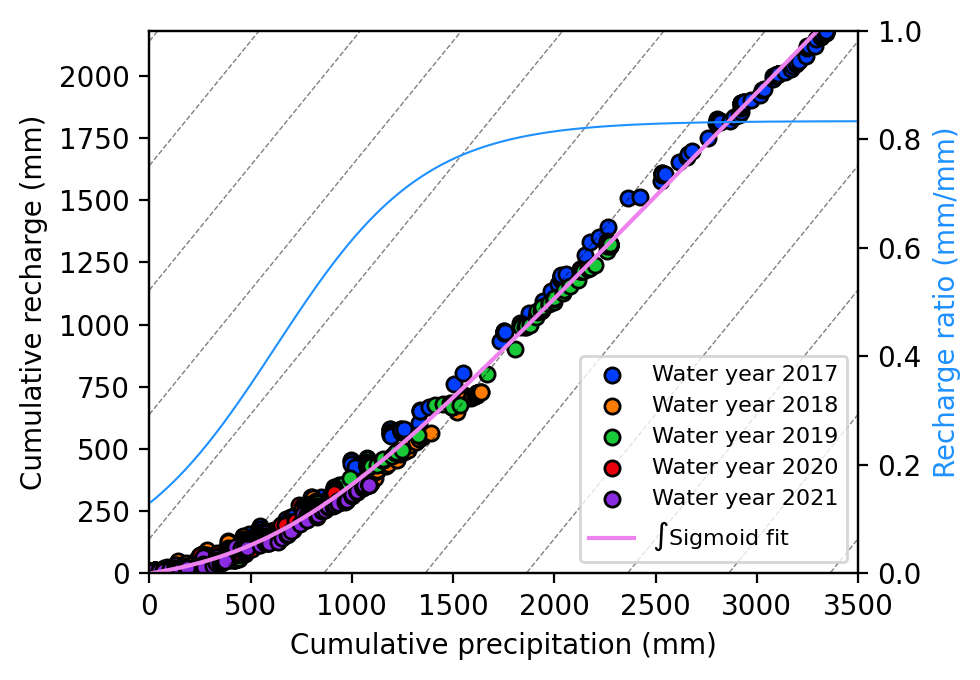

In [23]:
df['wy'] = [item.year if item.month<10 else item.year+1 for item in df.index]
df['sum_ppt'] = df.groupby('wy')['ppt'].cumsum()
df['sum_rt'] = df.groupby('wy')['rt'].cumsum()
df = df.loc[df.wy>2016]
wys = [2017,2018,2019,2020, 2021]
cs = sns.color_palette('viridis',len(wys))
xdata = []
ydata = []

cs = sns.color_palette('bright',len(wys))
f,ax = plt.subplots(1,figsize=(5,3.5))

for i,wy in enumerate(wys):
  temp = df.loc[((df.index.month>=10)|(df.index.month<=4))&(df.wy==wy)]
  temp = temp.loc[temp.sum_ppt<3500]
  temp = temp.iloc[1:]
  grad = np.gradient(temp.sum_rt, temp.sum_ppt)
  newxdata =  temp.sum_ppt.tolist()
  newydata = temp.sum_rt.tolist()
  xdata = xdata + newxdata
  ydata = ydata + newydata
  ax.scatter(newxdata, newydata, c=[cs[i]],ec='k',s=30,label='Water year %d'%wy)
xdata = np.array(xdata)
ydata = np.array(ydata)

cepts = np.arange(-2*np.max(ydata),np.max(ydata),500)
for cept in cepts[:-1]:
  xcept = np.max(ydata)
  ax.plot([0,xcept - cept],[cept,xcept],c='k',ls='--',alpha=0.5,lw=0.5)
cept = cepts[-1]
ax.plot([0,xcept - cept],[cept,xcept],c='k',alpha=0.5,ls='--',lw=0.5)

def logistic(x, L, x_0, k):
  y = L / (1 + np.exp(-k * (x - x_0)))
  y = [0] + list(scipy.integrate.cumtrapz(y,x))
  y = np.array(y)
  return y

def fun(x,a,h):
  return a*x + a*h*np.log(h) - a*h*np.log(h+x)

def fun(x,L,x_0,k):
  return (-(L*np.log(k + np.exp(k*x_0)*k)) + L*np.log(np.exp(k*x)*k + np.exp(k*x_0)*k))/k

idx = np.where(np.isfinite(xdata)&np.isfinite(ydata))[0]
p0 = [1,100,0.1]
popt, pcov = curve_fit(fun, xdata[idx], ydata[idx],p0,maxfev=10000)

xvar = np.linspace(np.min(xdata),2.1*np.max(xdata),1000)
y = fun(xvar, *popt)
ax.plot(xvar,y, c='violet',label=r'$\int \mathrm{Sigmoid}$ fit')

ax.set_xlim(0,np.max(xdata))
ax.set_ylim(0,np.max(ydata))
ax.set_ylabel('Cumulative recharge (mm)')
ax.legend(loc='upper left')

dy = np.gradient(y,xvar)
ax2 = ax.twinx()
ax2.plot(xvar,dy,c='dodgerblue',lw=0.75)
ax2.set_ylabel('Recharge ratio (mm/mm)',color='dodgerblue')
ax2.set_ylim(0,1)
ax.legend(fontsize=8,loc='lower right')
ax.set_xlim(0,3500)
ax.set_xlabel('Cumulative precipitation (mm)')

f.tight_layout()
f.savefig('./recharge_ratios.pdf',bbox_inches='tight')

In [79]:
%%capture
!pip install -q pydaymet
!pip install -q pynhd

from pynhd import NLDI
import pydaymet as daymet

In [90]:
# Grab PET data
geometry = NLDI().get_basins("11475560").geometry[0]
var = ["prcp", "tmin"]
dates = ("2016-10-01", "2021-09-30")
daily = daymet.get_bygeom(geometry, dates, variables=var, pet="hargreaves_samani", snow=True)
pet = daily.mean(dim=["x", "y"]).to_pandas()[['pet']]
pet.index = pd.to_datetime(pet.index.date)

In [89]:
print('Mean Nov - Mar PET = %.2f mm/day'%pet.loc[pet.index.month.isin([11,12,1,2,3])].pet.mean())
print('Mean Nov - Mar Q = %.2f mm/day'%df.loc[df.index.month.isin([11,12,1,2,3])].q.mean())
ai = pet.loc[pet.index.month.isin([11,12,1,2,3])].pet.mean()/df.loc[df.index.month.isin([11,12,1,2,3])].ppt.mean()
print('Aridity index Nov - Mar = %.2f'%ai)

Mean Nov - Mar PET = 1.25 mm/day
Mean Nov - Mar Q = 5.34 mm/day
Aridity index Nov - Mar = 0.14
